
# Assignment: RNN, LSTM, and GRU


## Cell 1 — Import required libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU


In [2]:

df = pd.read_csv("monthly_milk_production.csv")
df.head()


,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


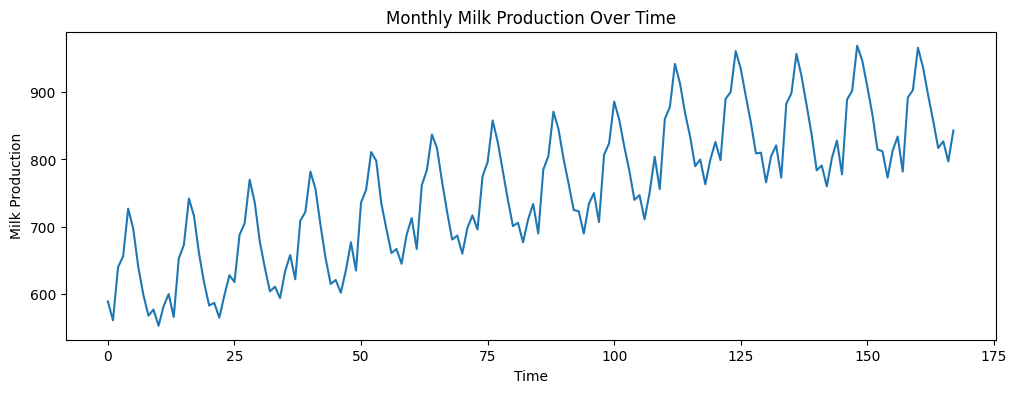

Missing values:
 Date          0
Production    0
dtype: int64

Summary statistics:
        Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


In [3]:

df.info()

plt.figure(figsize=(12,4))
plt.plot(df.iloc[:,1])
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Time")
plt.ylabel("Milk Production")
plt.show()

print("Missing values:\n", df.isna().sum())
print("\nSummary statistics:\n", df.describe())


In [13]:

scaler = MinMaxScaler()
milk_scaled = scaler.fit_transform(df.iloc[:,1].values.reshape(-1,1))
milk_scaled

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231],
       [0.        ],
       [0.06971154],
       [0.11298077],
       [0.03125   ],
       [0.24038462],
       [0.28846154],
       [0.45432692],
       [0.39182692],
       [0.25721154],
       [0.15384615],
       [0.07211538],
       [0.08173077],
       [0.02884615],
       [0.10817308],
       [0.18028846],
       [0.15625   ],
       [0.32451923],
       [0.36538462],
       [0.52163462],
       [0.43990385],
       [0.30048077],
       [0.20673077],
       [0.12259615],
       [0.13942308],
       [0.09855769],
       [0.19471154],
       [0.25240385],
       [0.16586538],
       [0.375     ],
       [0.40625   ],
       [0.55048077],
       [0.48798077],
       [0.35817308],
       [0.24038462],
       [0.14903846],
       [0.16346154],
       [0.11778846],
       [0.197

In [5]:

def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(milk_scaled, window_size)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (156, 12, 1)
y shape: (156, 1)


In [6]:

train_size = int(0.7 * len(X))
val_size = int(0.85 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (109, 12, 1) Val: (23, 12, 1) Test: (24, 12, 1)


In [7]:

def build_model(model_type, input_shape):
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(50, activation="tanh", input_shape=input_shape))
    elif model_type == "LSTM":
        model.add(LSTM(50, activation="tanh", input_shape=input_shape))
    elif model_type == "GRU":
        model.add(GRU(50, activation="tanh", input_shape=input_shape))

    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model


In [8]:
#Train RNN model
print("Training RNN")
rnn_model = build_model("RNN", (X_train.shape[1], X_train.shape[2]))
rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=0
)

# LSTM model
print("Training LSTM")
lstm_model = build_model("LSTM", (X_train.shape[1], X_train.shape[2]))
lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=0
)

# Train GRU model
print("Training GRU")
gru_model = build_model("GRU", (X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=0
)


models = {"RNN": rnn_model, "LSTM": lstm_model, "GRU": gru_model}

Training RNN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM
Training GRU


In [9]:
#model eval.
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_test_inv = scaler.inverse_transform(y_test)

# RNN evaluation
rnn_preds = rnn_model.predict(X_test)
rnn_preds_inv = scaler.inverse_transform(rnn_preds)

rnn_rmse = np.sqrt(mean_squared_error(y_test_inv, rnn_preds_inv))
rnn_mae = mean_absolute_error(y_test_inv, rnn_preds_inv)
rnn_mape = mape(y_test_inv, rnn_preds_inv)

#  LSTM evaluation
lstm_preds = lstm_model.predict(X_test)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)

lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_preds_inv))
lstm_mae = mean_absolute_error(y_test_inv, lstm_preds_inv)
lstm_mape = mape(y_test_inv, lstm_preds_inv)

#  GRU evaluation
gru_preds = gru_model.predict(X_test)
gru_preds_inv = scaler.inverse_transform(gru_preds)

gru_rmse = np.sqrt(mean_squared_error(y_test_inv, gru_preds_inv))
gru_mae = mean_absolute_error(y_test_inv, gru_preds_inv)
gru_mape = mape(y_test_inv, gru_preds_inv)

# Collect results into a table
results_df = pd.DataFrame({
    "Model": ["RNN", "LSTM", "GRU"],
    "RMSE": [rnn_rmse, lstm_rmse, gru_rmse],
    "MAE":  [rnn_mae,  lstm_mae,  gru_mae ],
    "MAPE": [rnn_mape, lstm_mape, gru_mape]
})

results_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


,Model,RMSE,MAE,MAPE
0,RNN,12.678475,10.007957,1.180858
1,LSTM,40.806402,32.219078,3.661100
2,GRU,36.464532,28.067657,3.299671


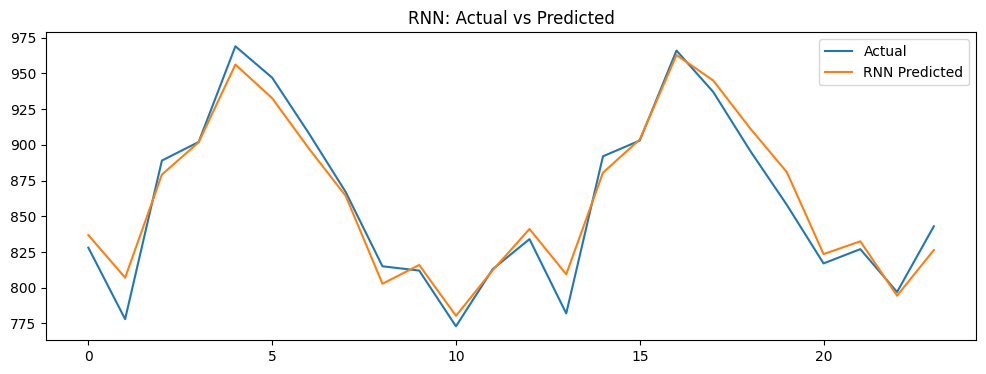

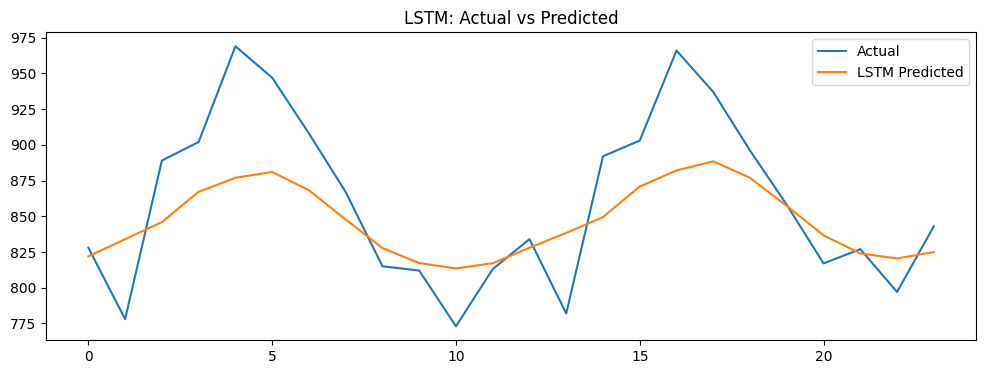

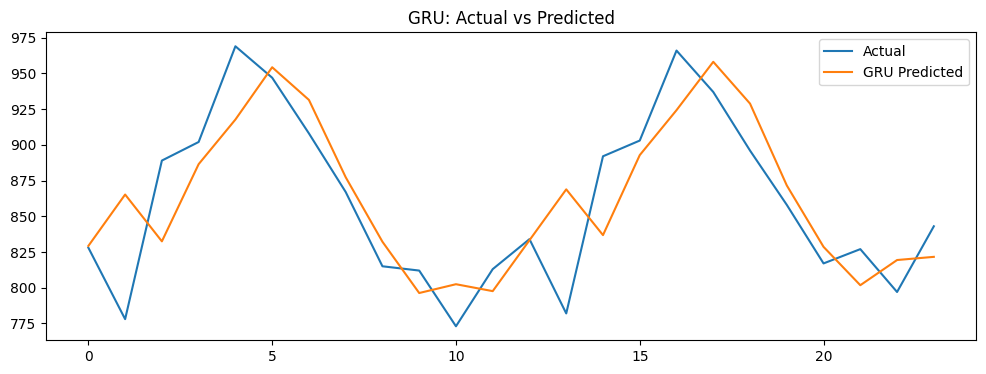

In [10]:
#  Plot 1: Actual vs Predicted (RNN)
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label="Actual")
plt.plot(rnn_preds_inv, label="RNN Predicted")
plt.title("RNN: Actual vs Predicted")
plt.legend()
plt.show()

#  Plot 2: Actual vs Predicted (LSTM)
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label="Actual")
plt.plot(lstm_preds_inv, label="LSTM Predicted")
plt.title("LSTM: Actual vs Predicted")
plt.legend()
plt.show()

#  Plot 3: Actual vs Predicted (GRU)
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label="Actual")
plt.plot(gru_preds_inv, label="GRU Predicted")
plt.title("GRU: Actual vs Predicted")
plt.legend()
plt.show()

## Cell 11 — Forecast next 12 months

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


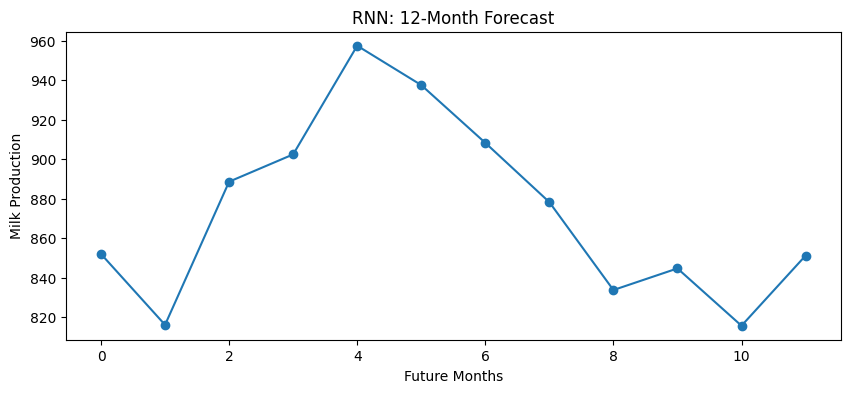

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


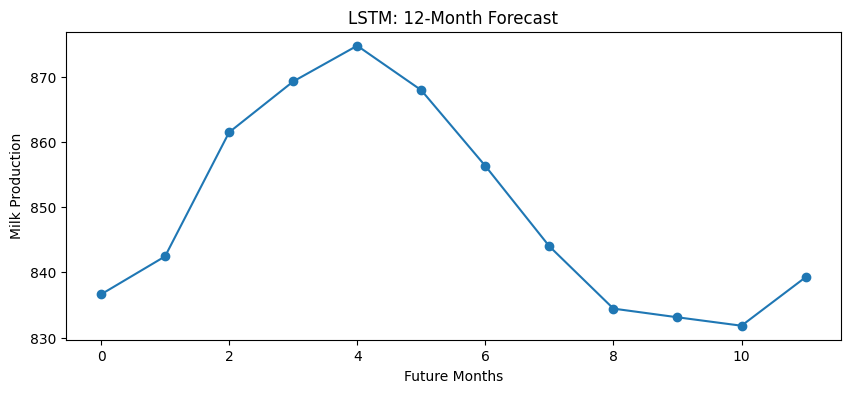

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


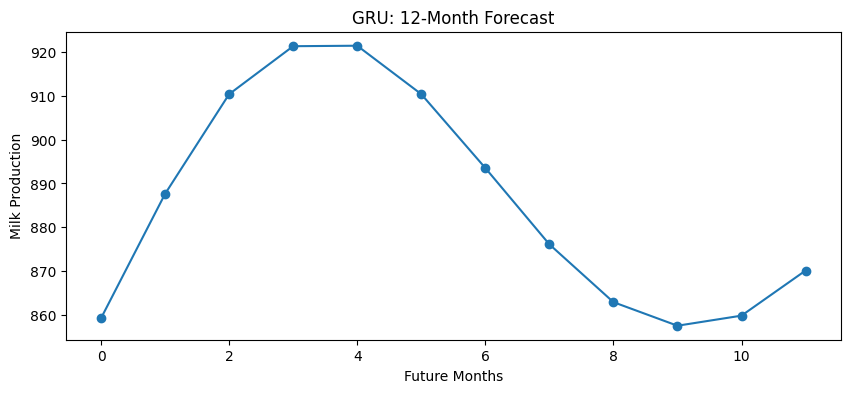

In [14]:
def forecast_next_12_months(model, last_window_scaled, window_size=12):
    """Forecast next 12 months using iterative (recursive) forecasting."""
    future_scaled = []
    current_input = last_window_scaled.copy()  # shape (window_size, 1)

    for _ in range(12):
        pred_scaled = model.predict(current_input.reshape(1, window_size, 1))
        future_scaled.append(pred_scaled[0, 0])
        current_input = np.append(current_input[1:], pred_scaled, axis=0)

    future_scaled = np.array(future_scaled).reshape(-1, 1)
    return scaler.inverse_transform(future_scaled)

last_window = milk_scaled[-window_size:]

#  RNN forecast
rnn_future = forecast_next_12_months(rnn_model, last_window, window_size)
plt.figure(figsize=(10,4))
plt.plot(rnn_future, marker="o")
plt.title("RNN: 12-Month Forecast")
plt.xlabel("Future Months")
plt.ylabel("Milk Production")
plt.show()

#  LSTM forecast
lstm_future = forecast_next_12_months(lstm_model, last_window, window_size)
plt.figure(figsize=(10,4))
plt.plot(lstm_future, marker="o")
plt.title("LSTM: 12-Month Forecast")
plt.xlabel("Future Months")
plt.ylabel("Milk Production")
plt.show()

#  GRU forecast
gru_future = forecast_next_12_months(gru_model, last_window, window_size)
plt.figure(figsize=(10,4))
plt.plot(gru_future, marker="o")
plt.title("GRU: 12-Month Forecast")
plt.xlabel("Future Months")
plt.ylabel("Milk Production")
plt.show()

## Based on the forecasted trend, the dairy business can proactively adjust cold storage capacity ahead of seasonal peaks and reduce wastage during low-production months.